Імпортуємо необхідні модулі:

In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression as logreg
import lightgbm as lgb
import sklearn.metrics as metrics
import shap
%matplotlib inline
import matplotlib.pyplot as plt

Шлях до файлу даних:

In [92]:
path_to_data=".\BA_Assessment_dataset.xlsx"

Загрузка даних:

In [93]:
data=pd.read_excel(path_to_data, sheet_name='Dataset_short', index_col=0)
original_data=data

In [94]:
# Rename the feature names to avoid special characters
original_names=list(data.columns)
feature_names = [f'feature_{i}' for i in range(data.shape[1])]
data.columns=feature_names

In [128]:
features=pd.DataFrame(original_names, feature_names)

In [130]:
features.to_excel('.\\feature_description.xlsx')

In [95]:
data

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
1            1          1          4          2          1          2   
2            2          1          4          2          1          2   
3            3          1          4          2          1          2   
4            2          1          4          2          1          2   
5            2          1          4          2          1          3   
..         ...        ...        ...        ...        ...        ...   
96           1          3          4          2          1          2   
97           3          1          4          2          1          3   
98           1          3          4          2          1          2   
99           3          1          4          2          1          3   
100          1          3          4          2          1          2   

     feature_6  feature_7  feature_8  feature_9  ...  feature_82  feature_83  \
1            2          2          3          2  ...           2           4   
2            2          2          3          2  ...           2           3   
3            2          2          3          2  ...           2           4   
4            2          2          3          2  ...           2           4   
5            2          2          3          2  ...           4           3   
..         ...        ...        ...        ...  ...         ...         ...   
96           2          2          3          2  ...           4           4   
97           2          2          3          2  ...           2           3   
98           2          2          3          2  ...           4           3   
99           2          2          3          2  ...           2           3   
100          2          2          3          2  ...           4           3   

     feature_84  feature_85  feature_86  feature_87  feature_88  feature_89  \
1             4           1           3           3           3           3   
2             4           1           1           2           3           3   
3             4           1           2           3           2           3   
4             4           1           2           2           3           2   
5             4           1           3           3           2           3   
..          ...         ...         ...         ...         ...         ...   
96            4           2           2           2           3           2   
97            4           2           3           3           3           2   
98            4           2           3           2           2           3   
99            4           2           3           3           3           2   
100           4           2           3           2           2           3   

     feature_90  feature_91  
1             3           3  
2             2           3  
3             3           3  
4             3           3  
5             2           3  
..          ...         ...  
96            3           3  
97            3           3  
98            3           3  
99            3           3  
100           3           3  

[100 rows x 92 columns]

In [96]:
# Розбиваємо дані на змінні цільові значення (train test split)
X,y=data.iloc[:,:-6], data.iloc[:,-6:]

In [97]:
X

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
1            1          1          4          2          1          2   
2            2          1          4          2          1          2   
3            3          1          4          2          1          2   
4            2          1          4          2          1          2   
5            2          1          4          2          1          3   
..         ...        ...        ...        ...        ...        ...   
96           1          3          4          2          1          2   
97           3          1          4          2          1          3   
98           1          3          4          2          1          2   
99           3          1          4          2          1          3   
100          1          3          4          2          1          2   

     feature_6  feature_7  feature_8  feature_9  ...  feature_76  feature_77  \
1            2          2          3          2  ...           3           3   
2            2          2          3          2  ...           3           3   
3            2          2          3          2  ...           2           3   
4            2          2          3          2  ...           3           3   
5            2          2          3          2  ...           2           3   
..         ...        ...        ...        ...  ...         ...         ...   
96           2          2          3          2  ...           3           3   
97           2          2          3          2  ...           3           3   
98           2          2          3          2  ...           2           3   
99           2          2          3          2  ...           3           3   
100          2          2          3          2  ...           2           3   

     feature_78  feature_79  feature_80  feature_81  feature_82  feature_83  \
1             2           2           3           2           2           4   
2             1           3           2           1           2           3   
3             2           2           2           2           2           4   
4             1           3           3           3           2           4   
5             1           2           2           2           4           3   
..          ...         ...         ...         ...         ...         ...   
96            3           1           3           2           4           4   
97            1           2           2           2           2           3   
98            3           2           3           2           4           3   
99            1           2           2           2           2           3   
100           3           2           3           2           4           3   

     feature_84  feature_85  
1             4           1  
2             4           1  
3             4           1  
4             4           1  
5             4           1  
..          ...         ...  
96            4           2  
97            4           2  
98            4           2  
99            4           2  
100           4           2  

[100 rows x 86 columns]

In [98]:
# Ця функція тренує lightgbm та вертає результати
def train_lgbm(X,y,n_folds,params):
    kf = StratifiedKFold(n_splits=n_folds)
    # Splitting the data
    accs=[]
    f1s=[]
    aucs=[]
    lgbcs=[]
    all_preds=[]
    for i in range(6):
        acc_per_split=[]
        for train_index, test_index in kf.split(X,y.iloc[:,i]):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[:,i].iloc[train_index], y.iloc[:,i].iloc[test_index]
            train_dataset = lgb.Dataset(X_train, label=y_train)
            lgbc=lgb.train(train_set=train_dataset, params=params)
            y_preds=lgbc.predict(X_test)
            y_preds=y_preds.argmax(axis=1)
            acc=metrics.accuracy_score(y_test, y_preds)
            acc_per_split.append(acc)
            f1=metrics.f1_score(y_test, y_preds, average='micro')
            f1s.append(f1)
            #prec=
            #rec=
        accs.append(acc_per_split)
        lgbcs.append(lgbc)
    accs=np.array(accs)
    return y_test, y_preds, accs, lgbcs, f1s

In [99]:
params = {
    'objective': 'multiclass',
    #'metric': 'auc',
    'verbose': 0,
    'num_class':5,
    'max_depth':7
}

In [100]:
res=train_lgbm(X,y,5,params)

The least populated class in y has only 2 members, which is less than n_splits=5.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

The least populated class in y has only 2 members, which is less than n_splits=5.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

The least populated class in y has only 2 members, which is less than n_splits=5.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

The least populated class in y has only 4 members, which is less than n_splits=5.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [101]:
res

(79     4
 80     4
 81     4
 82     4
 83     4
 84     4
 85     4
 86     4
 87     4
 88     4
 89     3
 92     2
 93     3
 94     1
 95     3
 96     3
 97     3
 98     3
 99     3
 100    3
 Name: feature_91, dtype: int64,
 array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3],
       dtype=int64),
 array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]),
  <lightgbm.basic.Booster at 0x1cf4532bb10>])

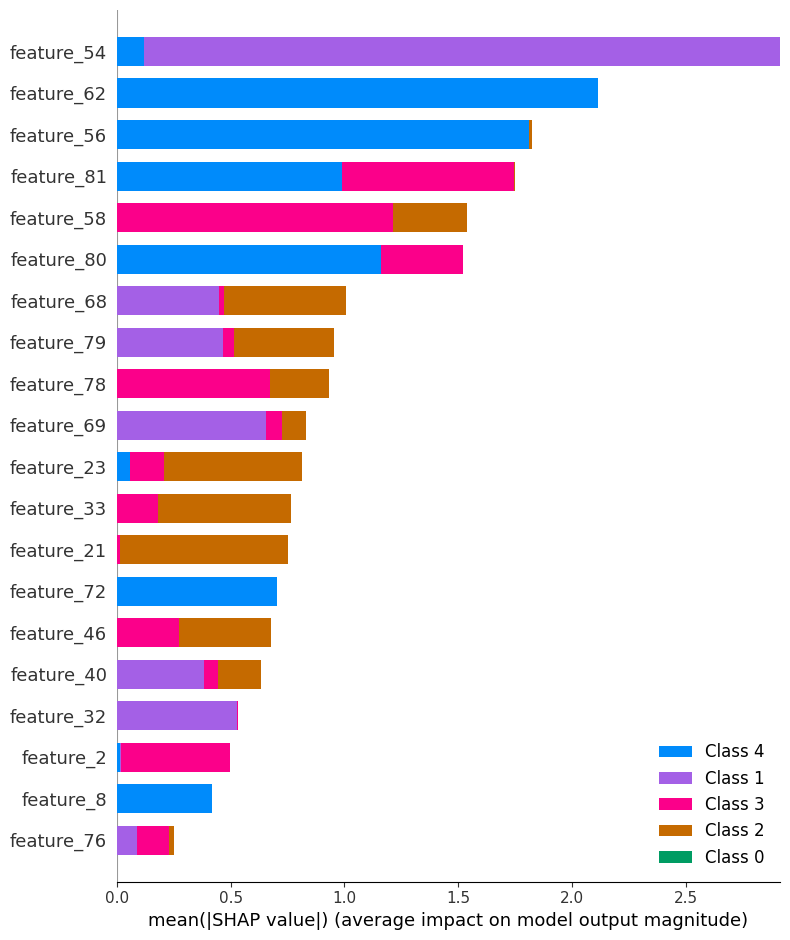

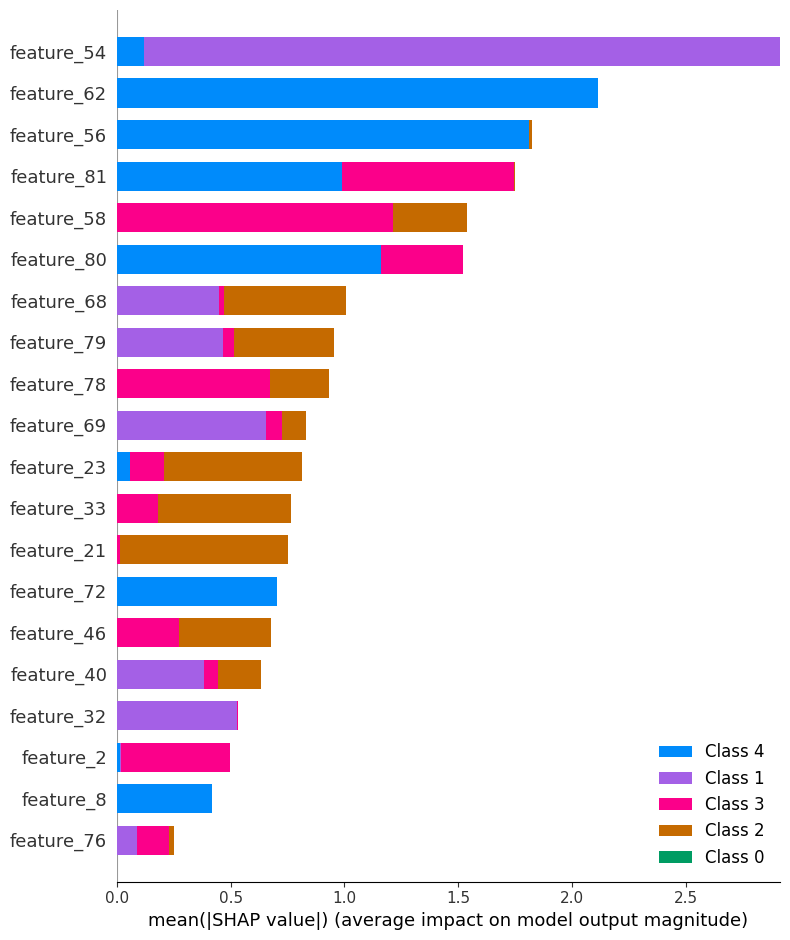

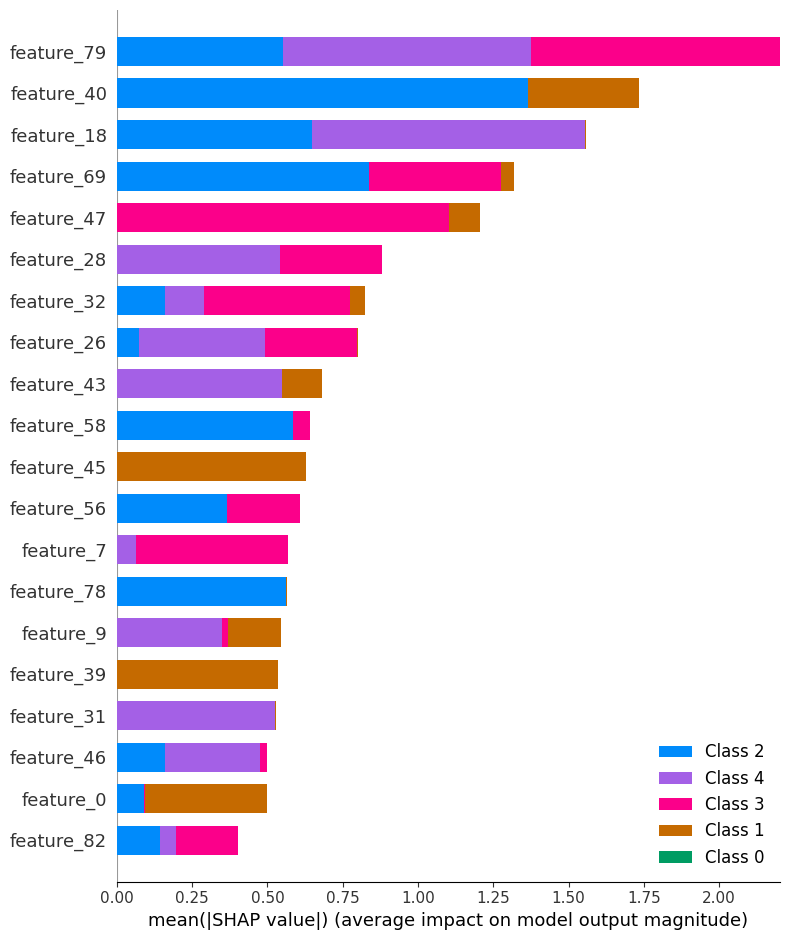

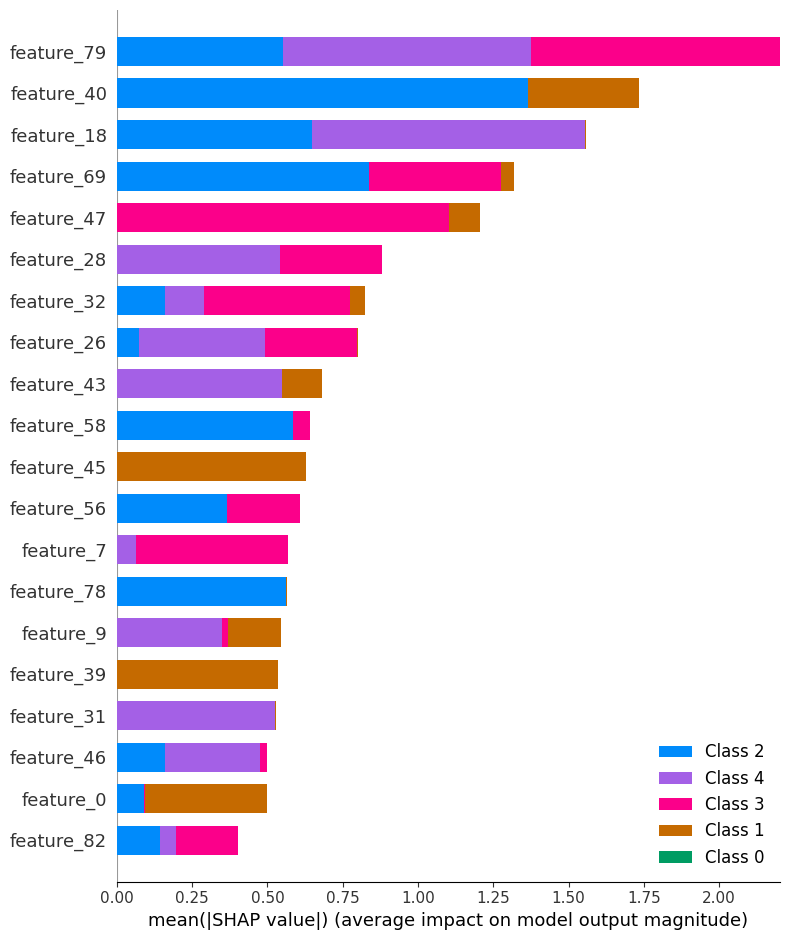

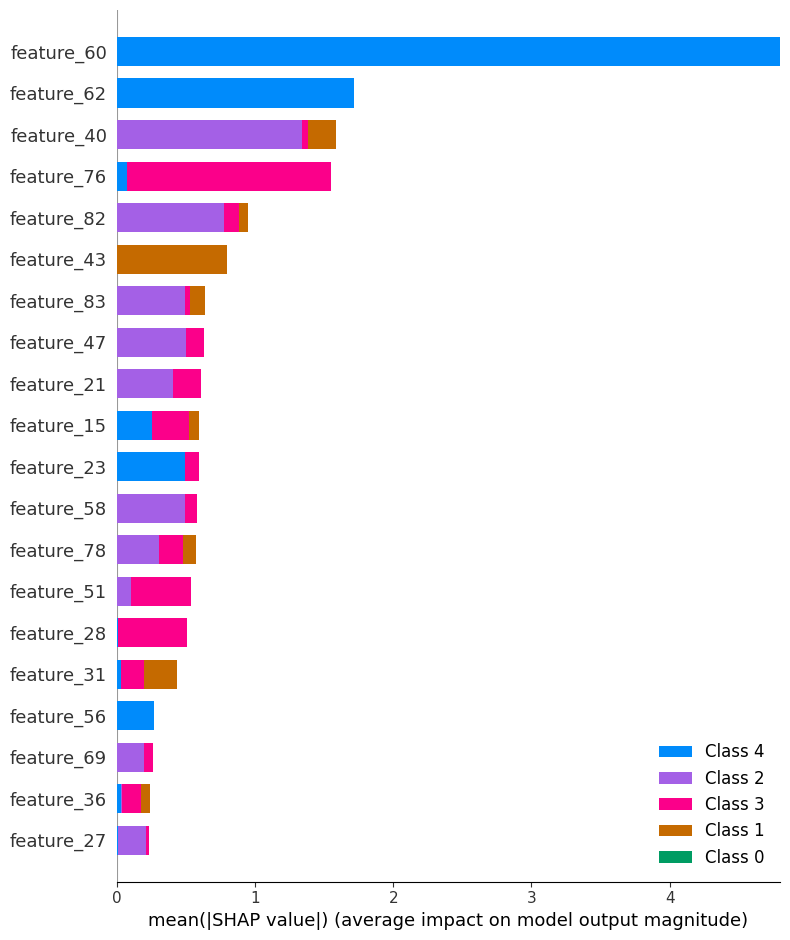

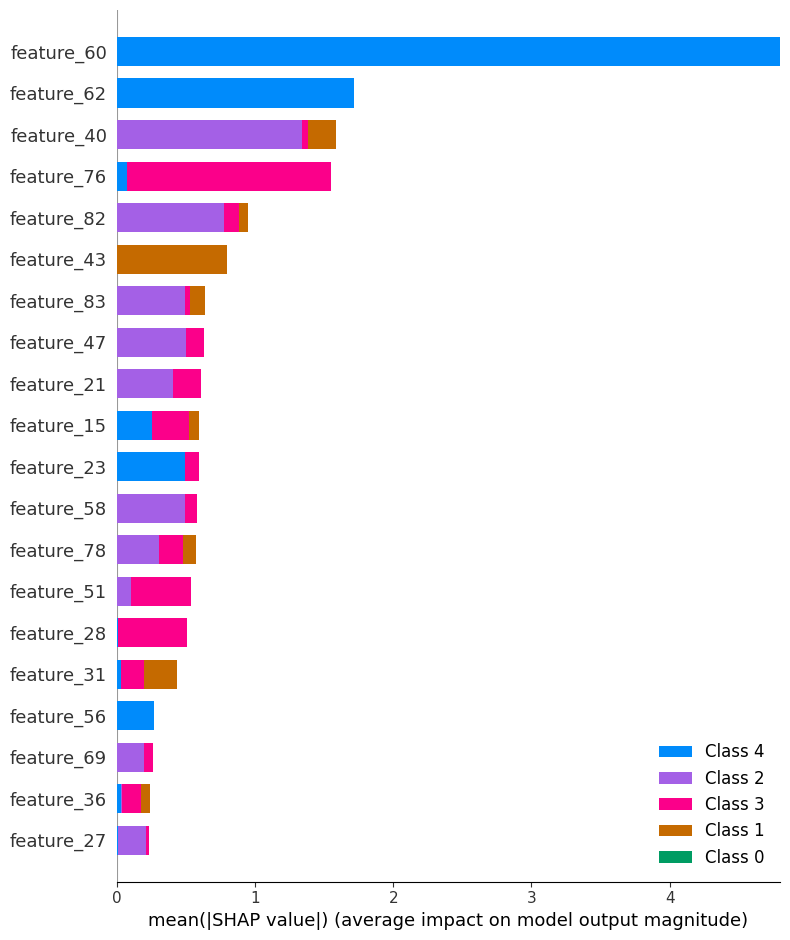

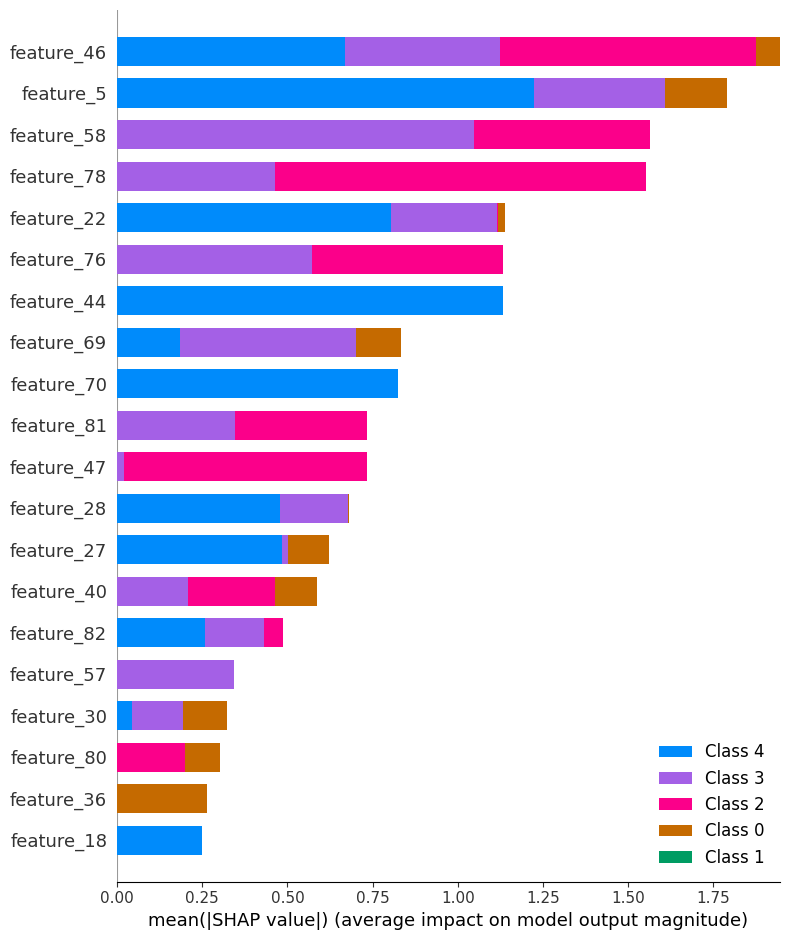

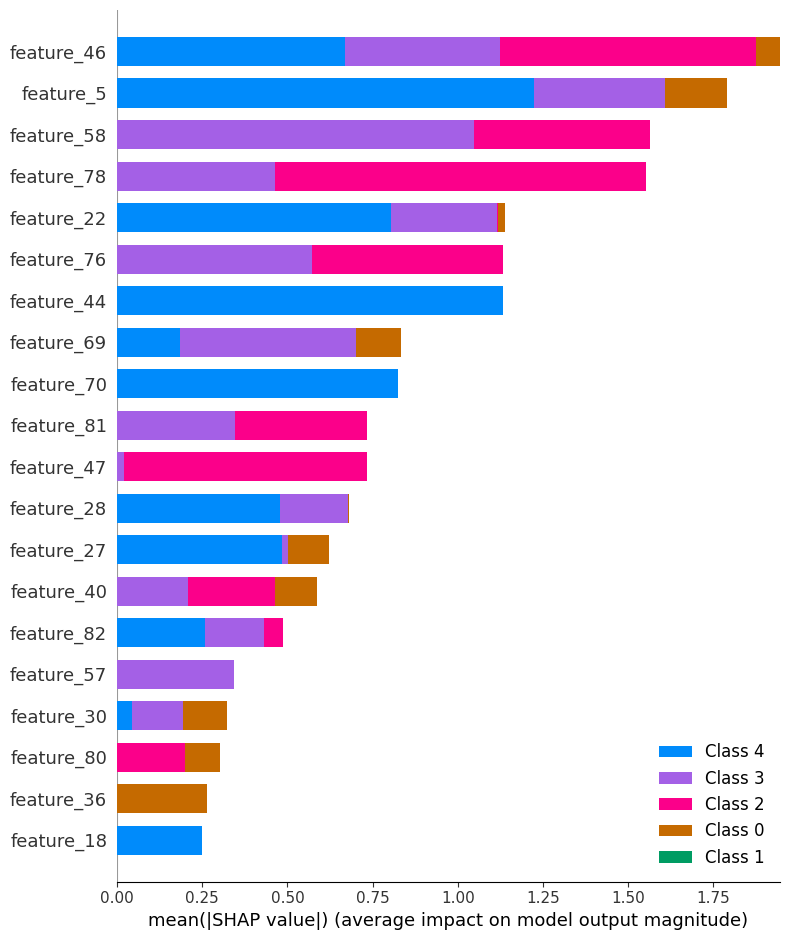

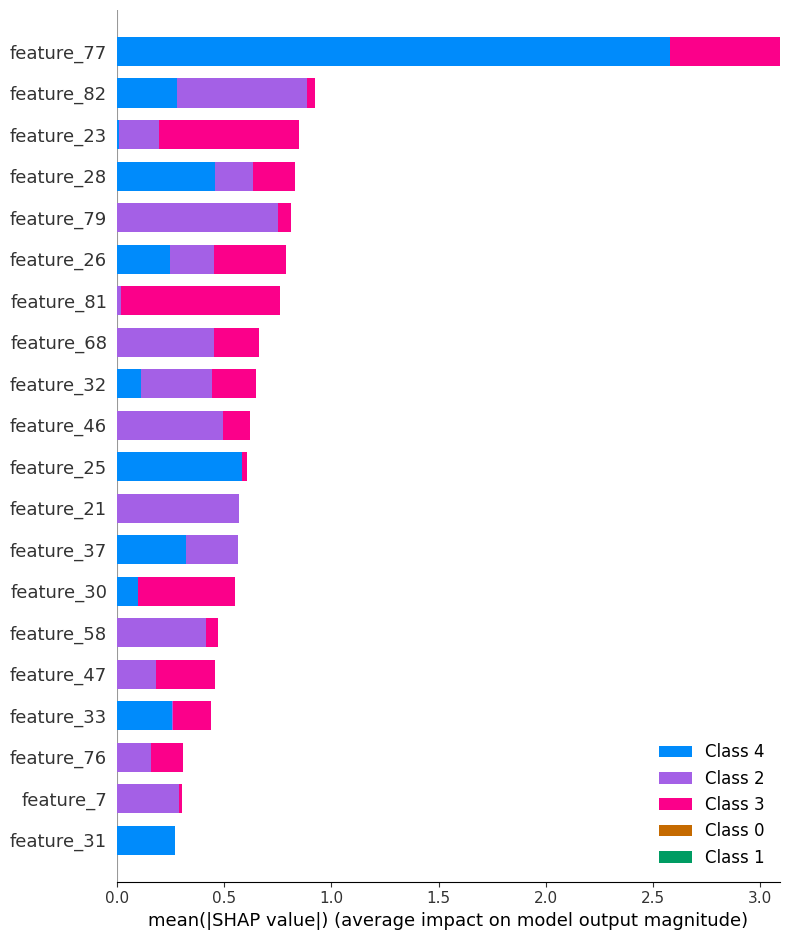

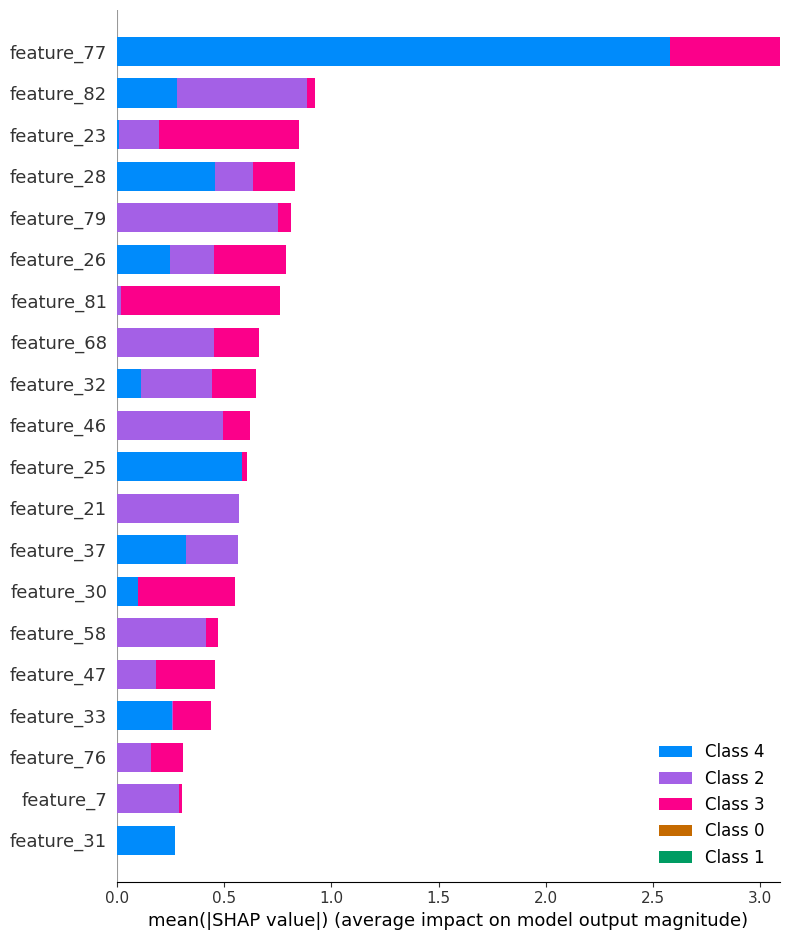

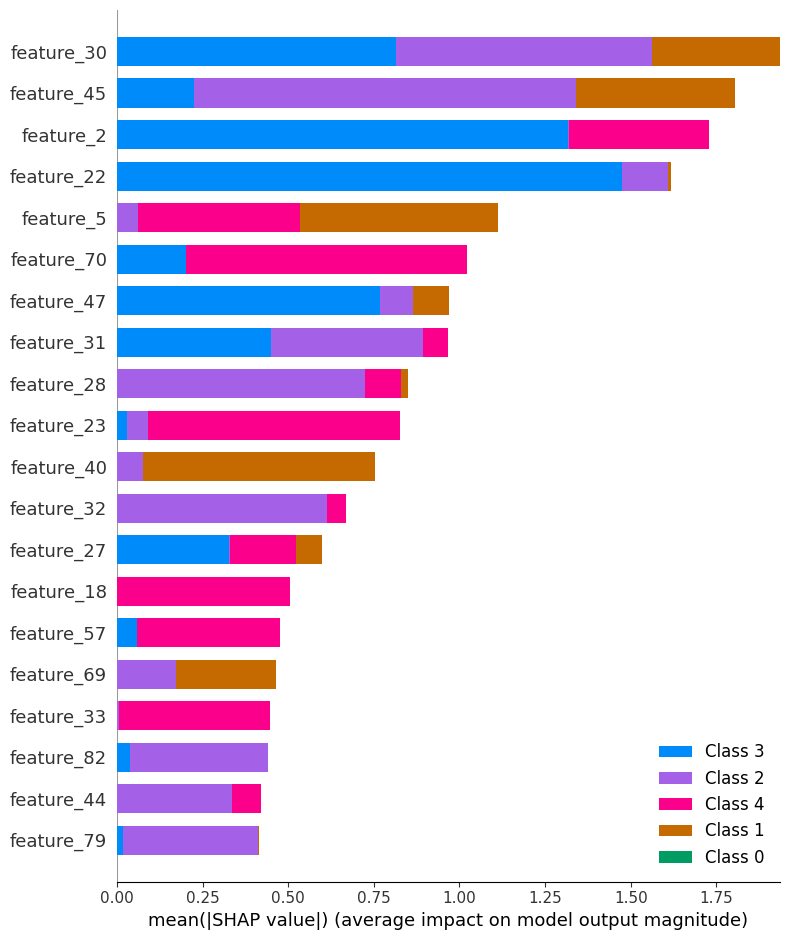

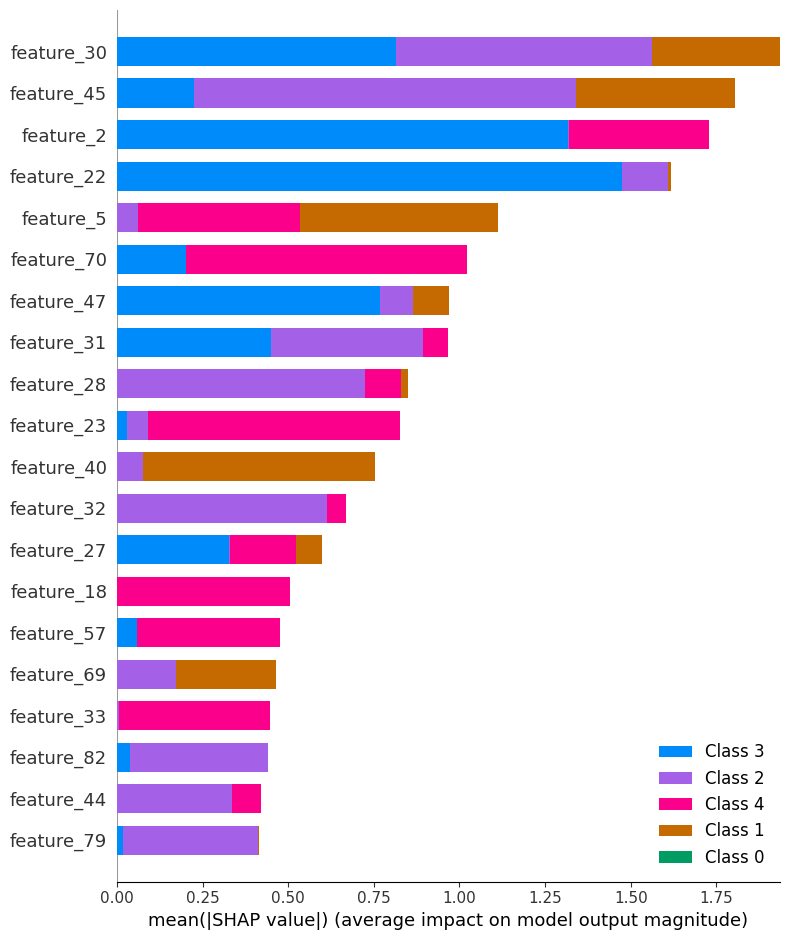

In [102]:
shap.initjs()    
plt.figure(figsize=(3,2))
for i in range(6):
    explainer = shap.TreeExplainer(res[3][i])
    shap_values = explainer.shap_values(X)
    ax = shap.summary_plot(shap_values, X)

    # Adjust y-axis label size
    for label in plt.gca().get_yticklabels():
        label.set_fontsize(4)  # Adjust '8' to your preference

    shap.summary_plot(shap_values, X)
    #plt.show()
    #plt.gcf().canvas.draw()

In [103]:
# Ця функція тренує RandomForest та вертає результати
def train_rfc(X,y,n_folds,params):
    kf = StratifiedKFold(n_splits=n_folds)
    # Splitting the data
    accs=[]
    f1s=[]
    aucs=[]
    rfcs=[]
    all_preds=[]
    for i in range(6):
        acc_per_split=[]
        for train_index, test_index in kf.split(X,y.iloc[:,i]):
            X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
            y_train, y_test = y.iloc[:,i].iloc[train_index].values, y.iloc[:,i].iloc[test_index].values
            rf=rfc(max_depth=3, min_samples_split=2)
            rf.fit(X_test, y_test)
            y_preds=rf.predict(X_test)
            y_preds=y_preds
            acc=metrics.accuracy_score(y_test, y_preds)
            acc_per_split.append(acc)
            f1=metrics.f1_score(y_test, y_preds, average='micro')
            f1s.append(f1)
            #prec=
            #rec=
        accs.append(acc_per_split)
        rfcs.append(rf)
    accs=np.array(accs)
    return y_test, y_preds, accs, rfcs, f1s

In [104]:
res=train_rfc(X,y,5,params)

The least populated class in y has only 2 members, which is less than n_splits=5.
The least populated class in y has only 2 members, which is less than n_splits=5.
The least populated class in y has only 2 members, which is less than n_splits=5.
The least populated class in y has only 4 members, which is less than n_splits=5.


In [105]:
res

(array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3],
       dtype=int64),
 array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3],
       dtype=int64),
 array([[1.  , 1.  , 1.  , 1.  , 1.  ],
        [1.  , 0.95, 1.  , 0.95, 1.  ],
        [1.  , 1.  , 1.  , 1.  , 1.  ],
        [0.95, 0.95, 0.95, 1.  , 1.  ],
        [1.  , 0.95, 0.95, 0.95, 1.  ],
        [1.  , 1.  , 1.  , 1.  , 1.  ]]),
 [RandomForestClassifier(max_depth=3),
  RandomForestClassifier(max_depth=3),
  RandomForestClassifier(max_depth=3),
  RandomForestClassifier(max_depth=3),
  RandomForestClassifier(max_depth=3),
  RandomForestClassifier(max_depth=3)])

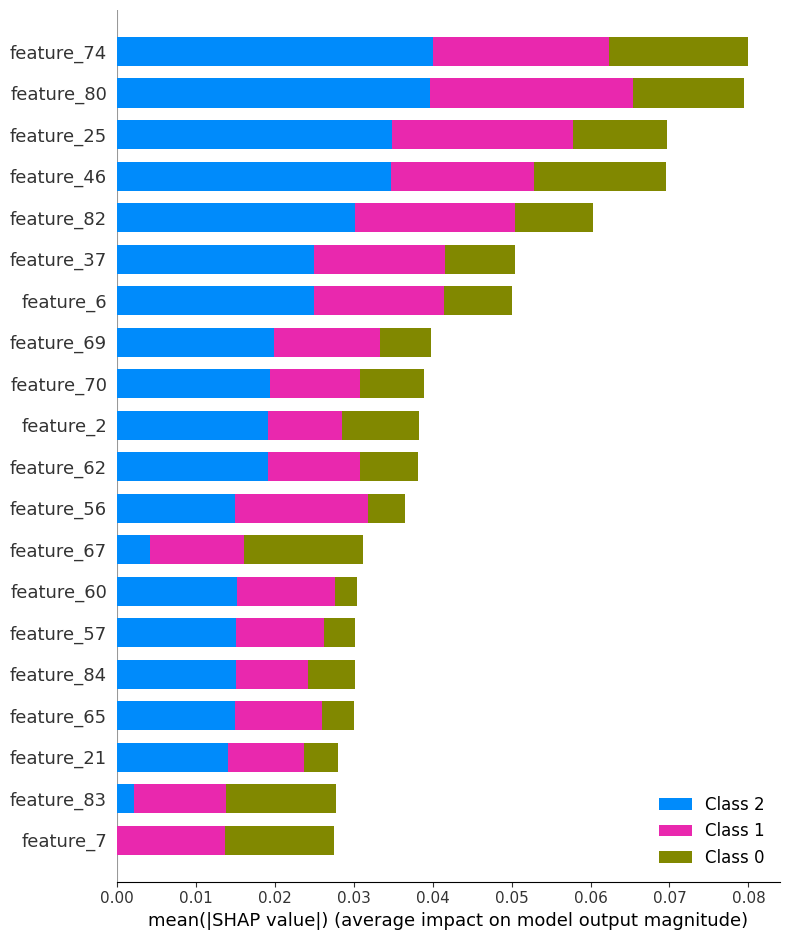

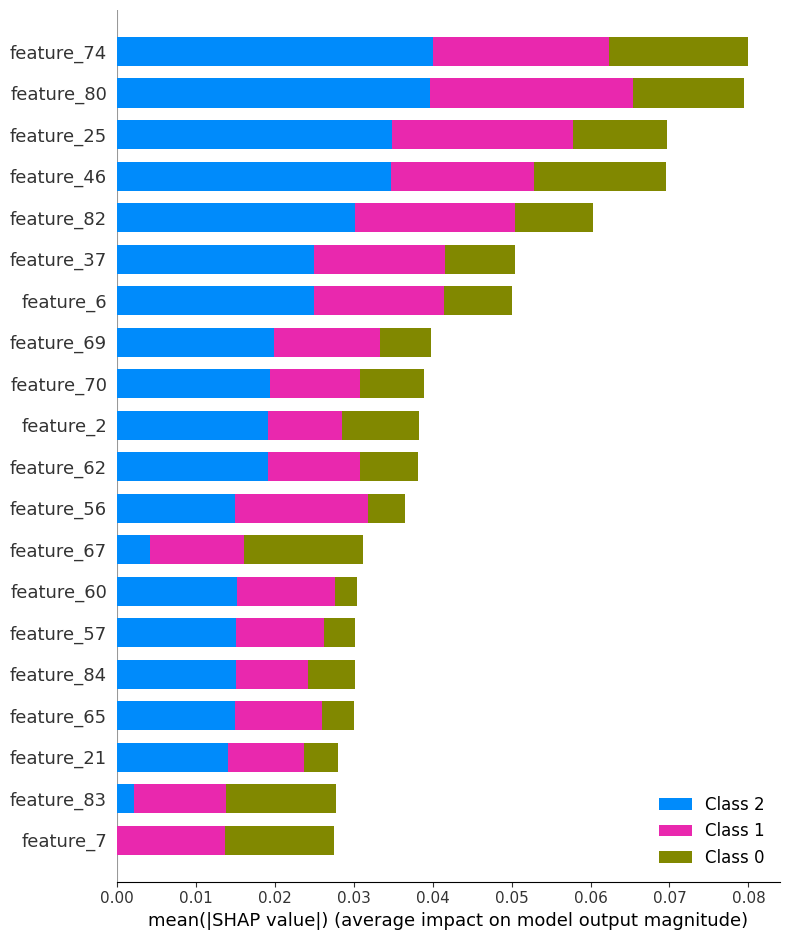

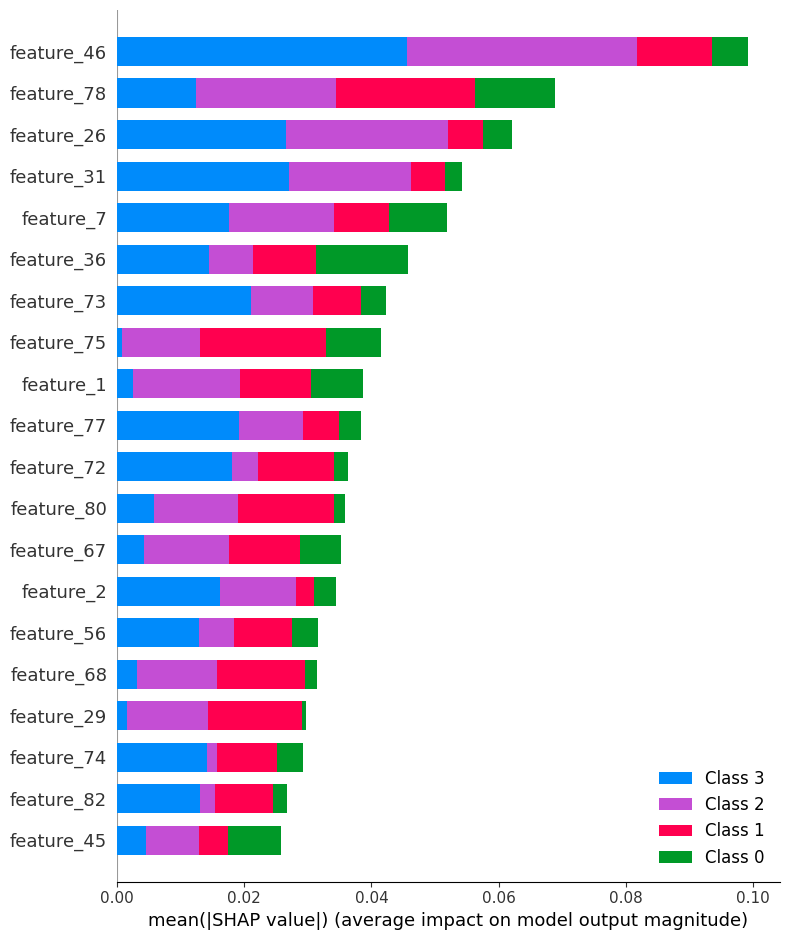

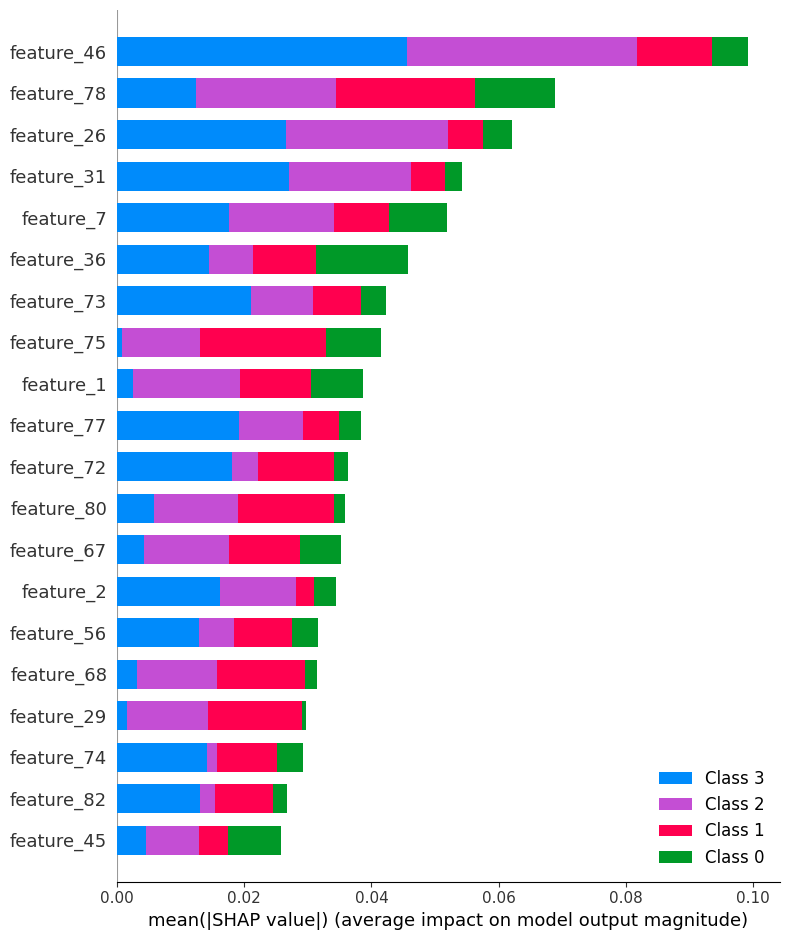

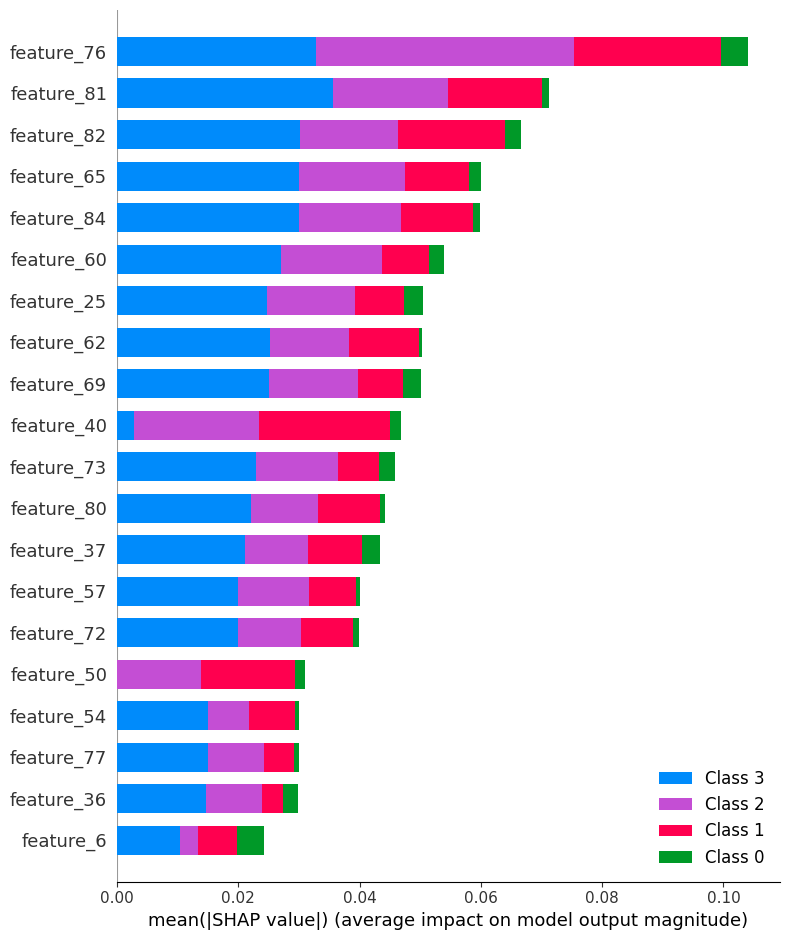

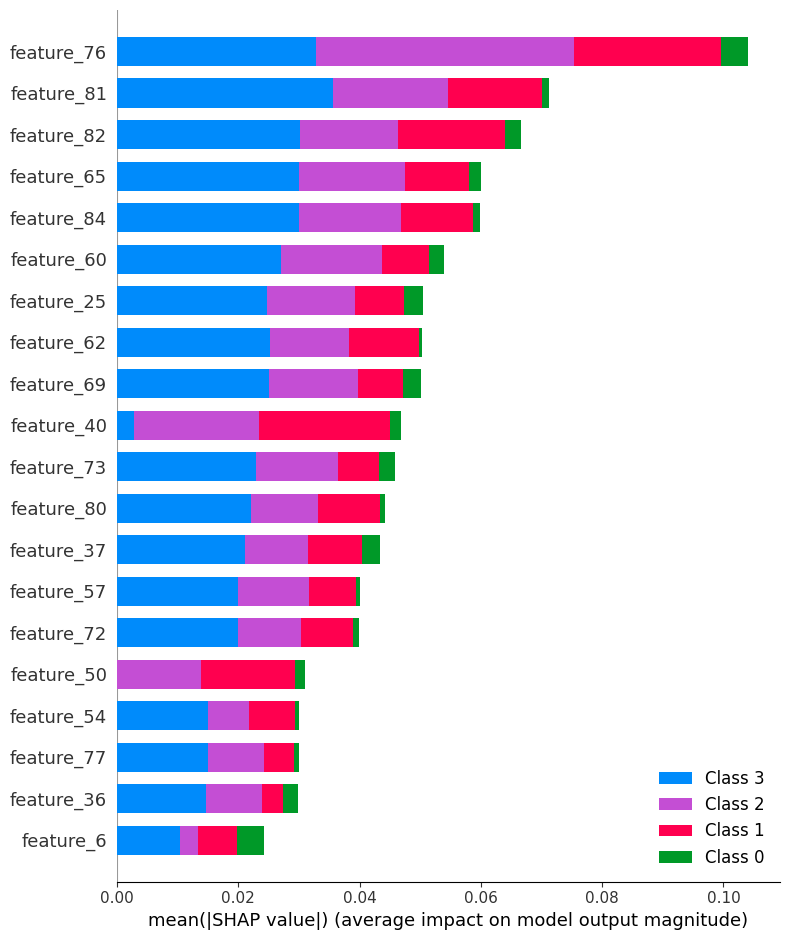

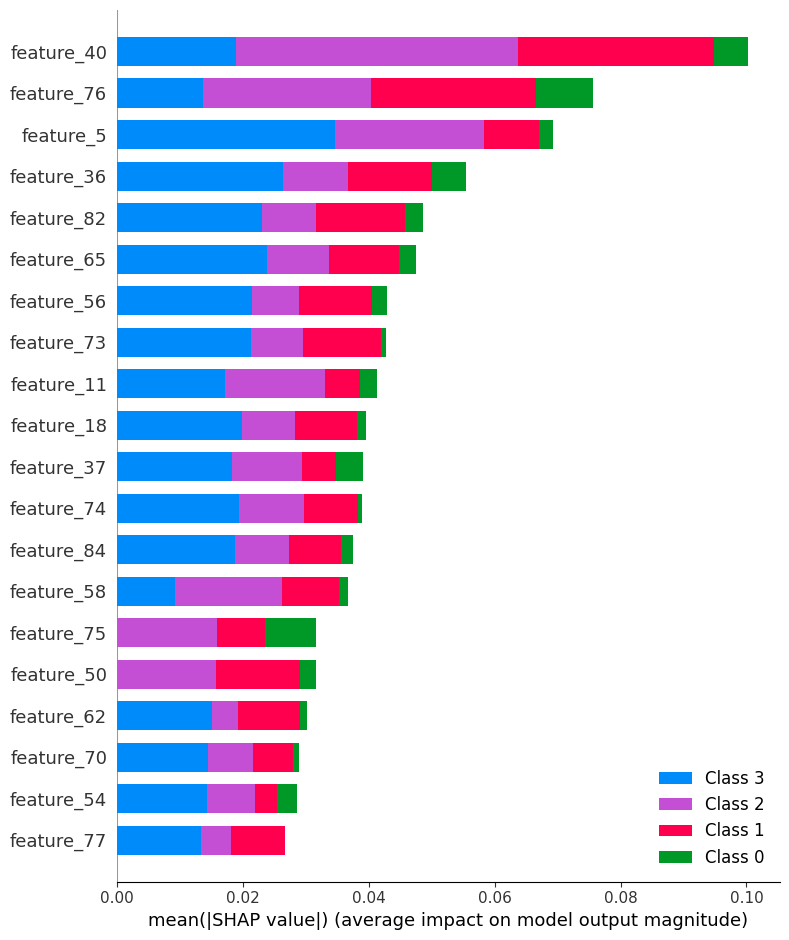

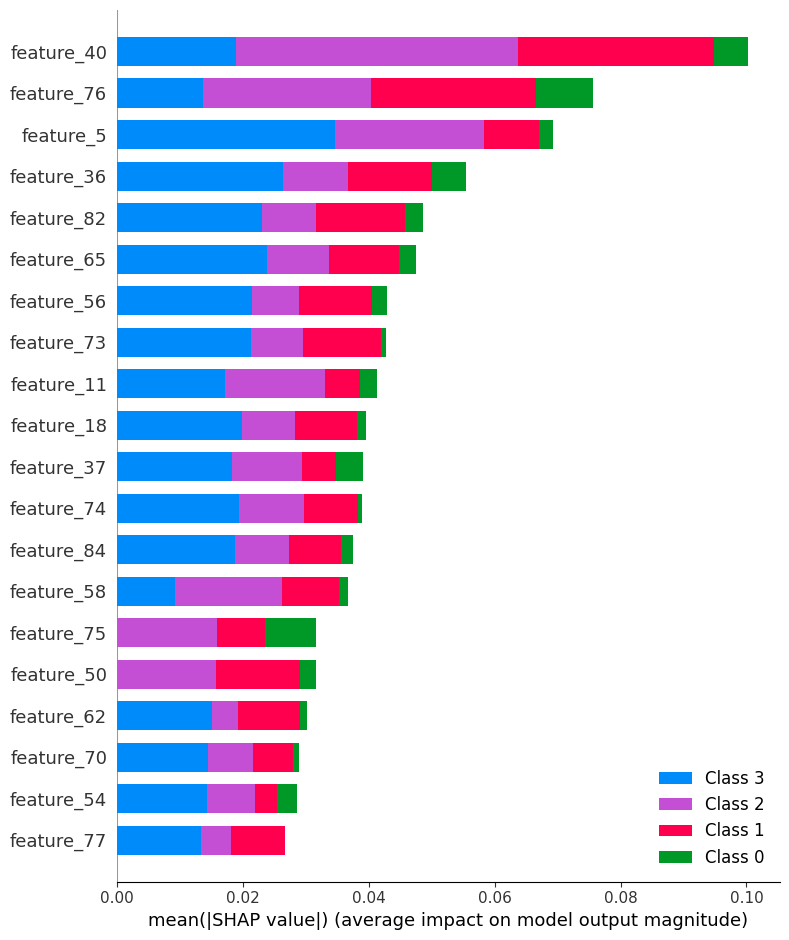

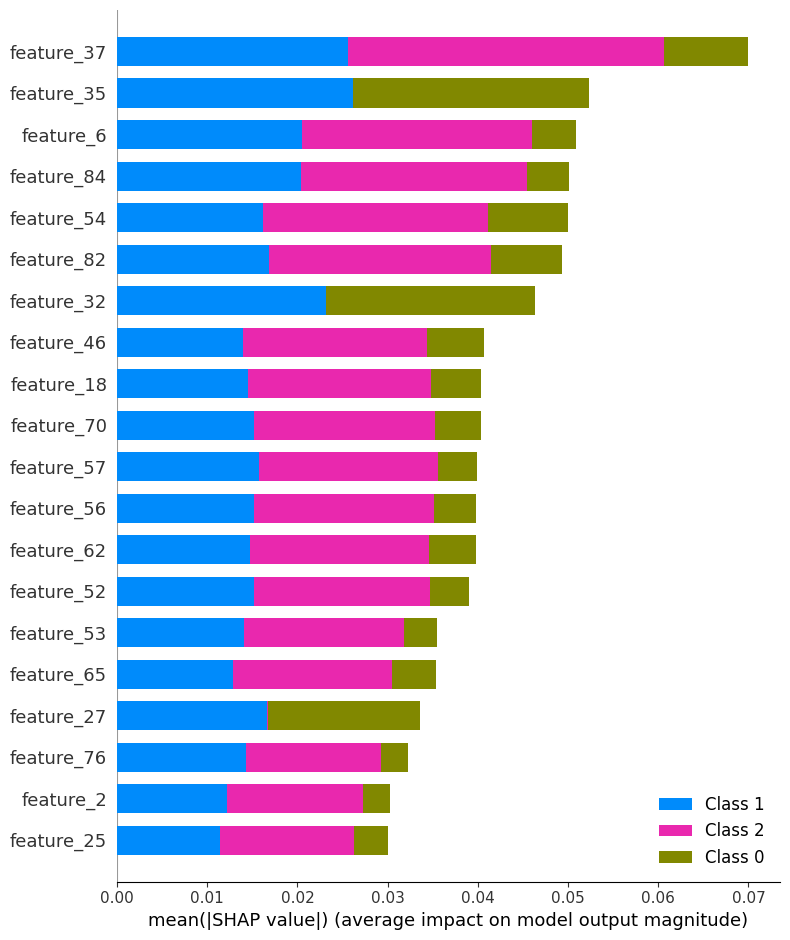

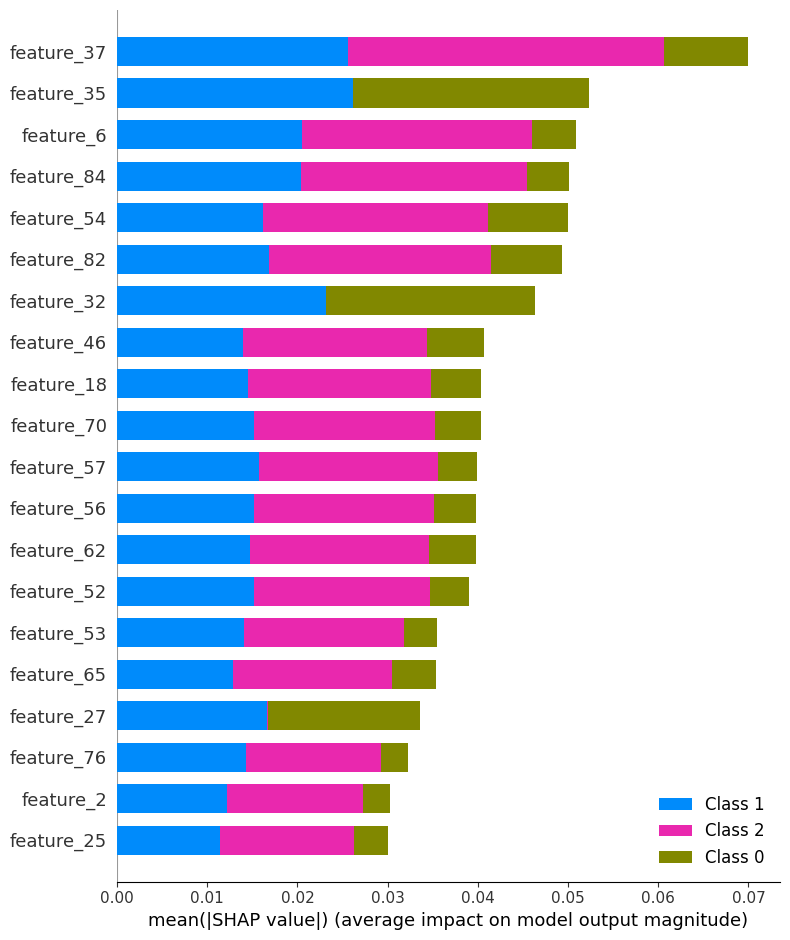

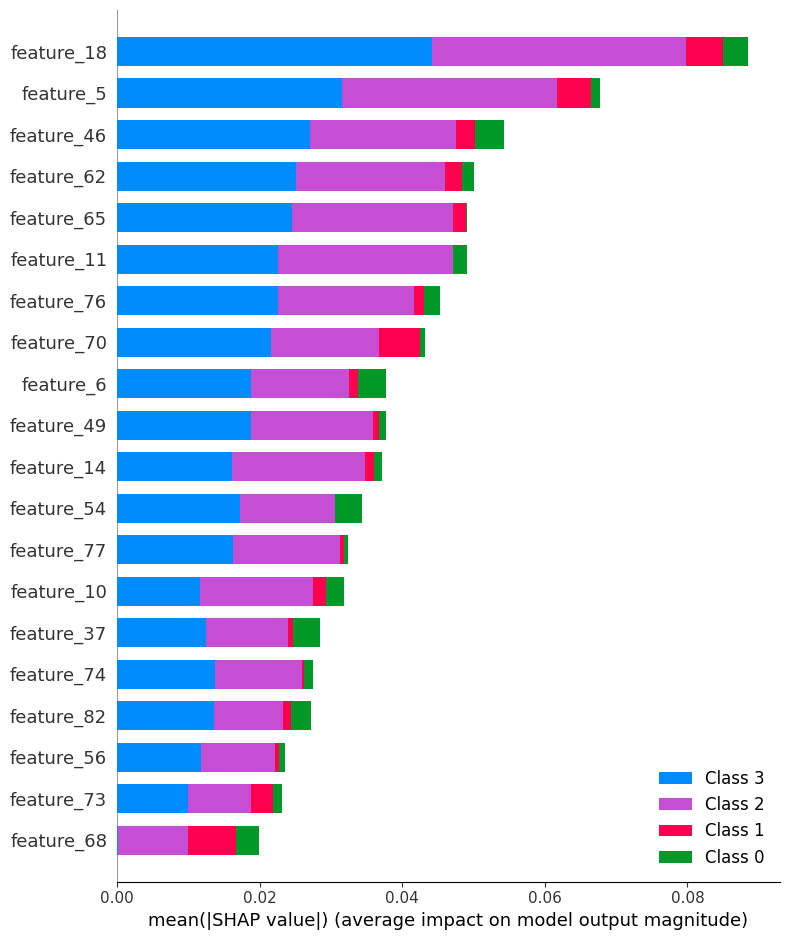

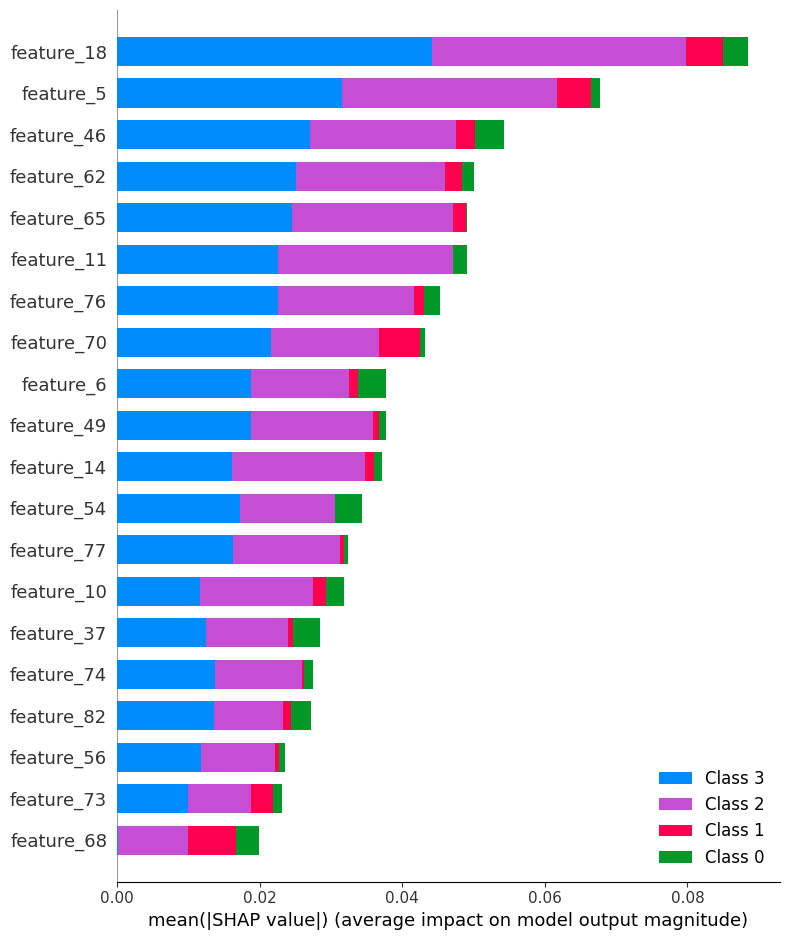

In [106]:
shap.initjs()    
plt.figure(figsize=(3,2))
for i in range(6):
    explainer = shap.TreeExplainer(res[3][i])
    shap_values = explainer.shap_values(X)
    ax = shap.summary_plot(shap_values, X)

    # Adjust y-axis label size
    for label in plt.gca().get_yticklabels():
        label.set_fontsize(4)  # Adjust '8' to your preference

    shap.summary_plot(shap_values, X)
    #plt.show()
    #plt.gcf().canvas.draw()

In [131]:
def train_logreg(X,y,n_folds,params):
    kf = StratifiedKFold(n_splits=n_folds)
    # Splitting the data
    accs=[]
    f1s=[]
    aucs=[]
    rfcs=[]
    all_preds=[]
    for i in range(6):
        acc_per_split=[]
        for train_index, test_index in kf.split(X,y.iloc[:,i]):
            X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
            y_train, y_test = y.iloc[:,i].iloc[train_index].values, y.iloc[:,i].iloc[test_index].values
            rf=logreg(max_iter=1000)
            rf.fit(X_test, y_test)
            y_preds=rf.predict(X_test)
            y_preds=y_preds
            acc=metrics.accuracy_score(y_test, y_preds)
            acc_per_split.append(acc)
            f1=metrics.f1_score(y_test, y_preds, average='micro')
            f1s.append(f1)
            #prec=
            #rec=
        accs.append(acc_per_split)
        rfcs.append(rf)
    accs=np.array(accs)
    return y_test, y_preds, accs, rfcs, f1s

In [132]:
res=train_logreg(X,y,5,params)

The least populated class in y has only 2 members, which is less than n_splits=5.
The least populated class in y has only 2 members, which is less than n_splits=5.
The least populated class in y has only 2 members, which is less than n_splits=5.
The least populated class in y has only 4 members, which is less than n_splits=5.


In [133]:
res

(array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3],
       dtype=int64),
 array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3],
       dtype=int64),
 array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]),
 [LogisticRegression(max_iter=1000),
  LogisticRegression(max_iter=1000),
  LogisticRegression(max_iter=1000),
  LogisticRegression(max_iter=1000),
  LogisticRegression(max_iter=1000),
  LogisticRegression(max_iter=1000)],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0])

In [118]:
def model_predict(data, model):
    return model.predict(data)

X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names

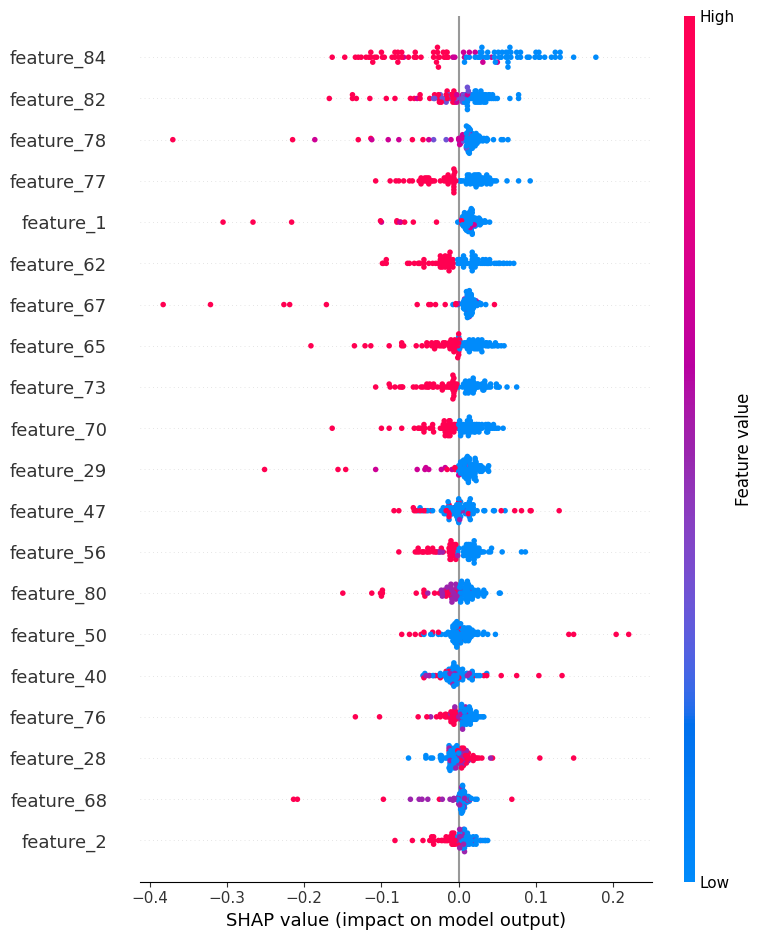

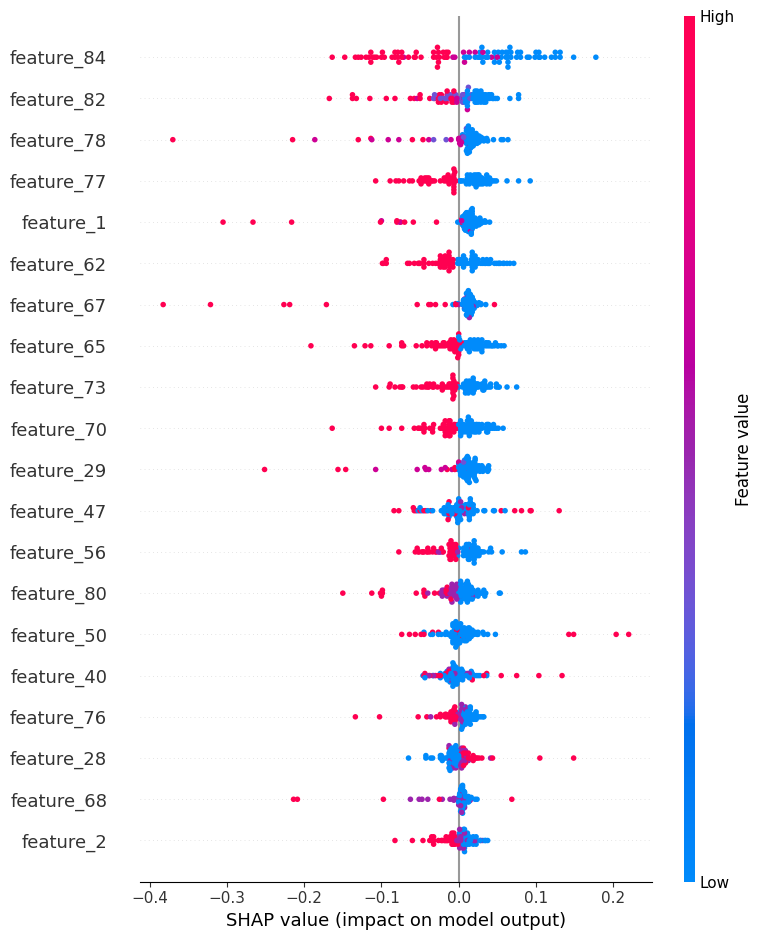

X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names

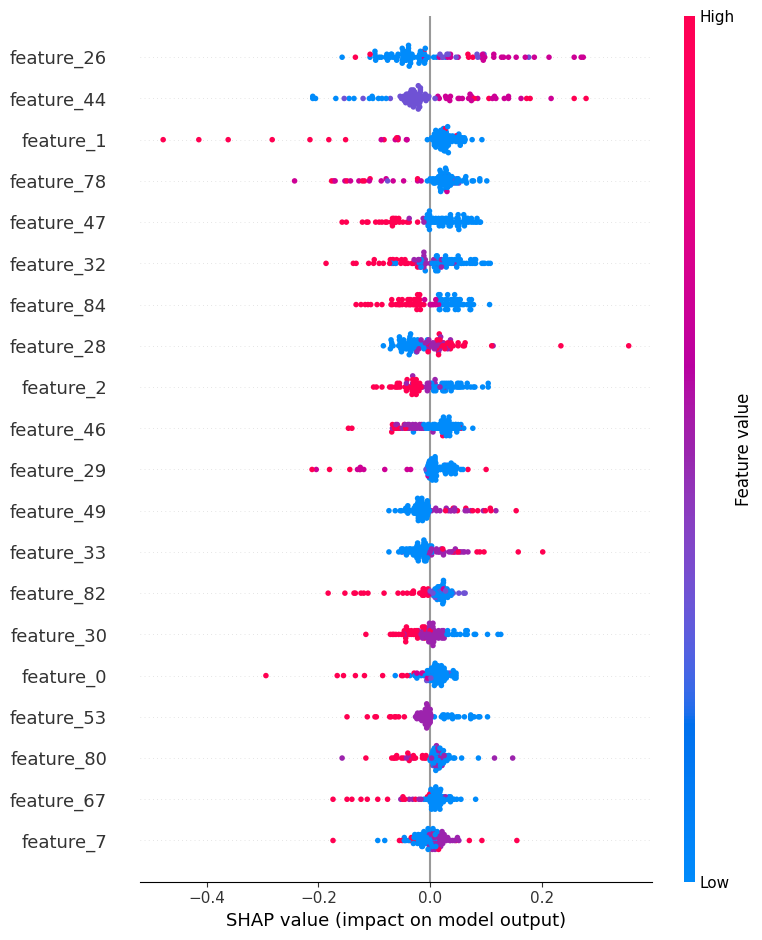

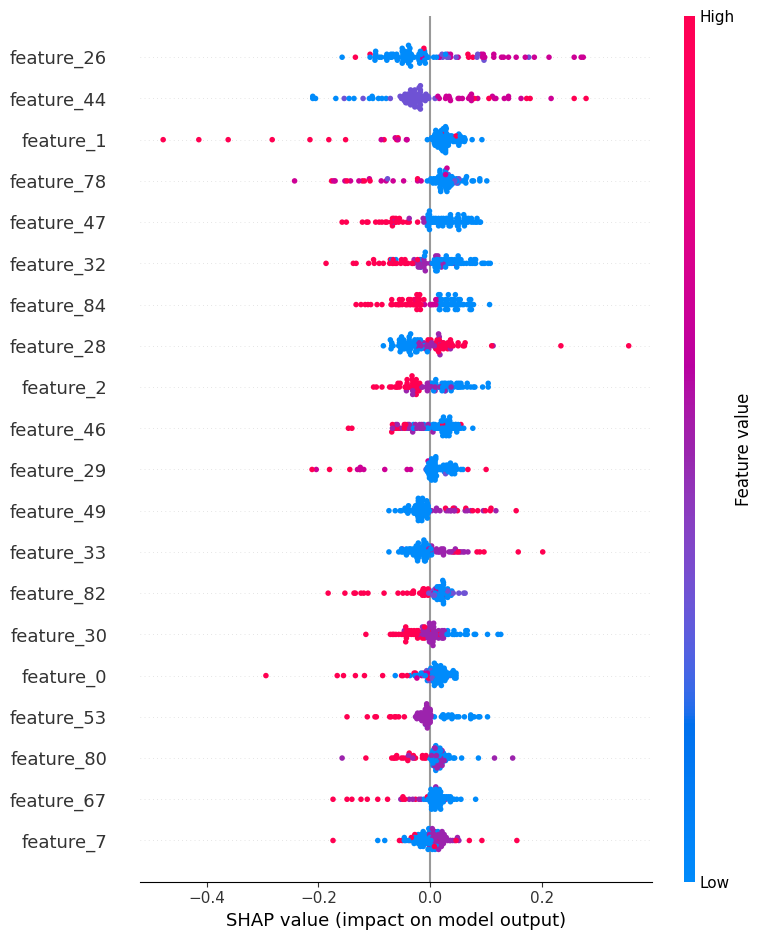

X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names

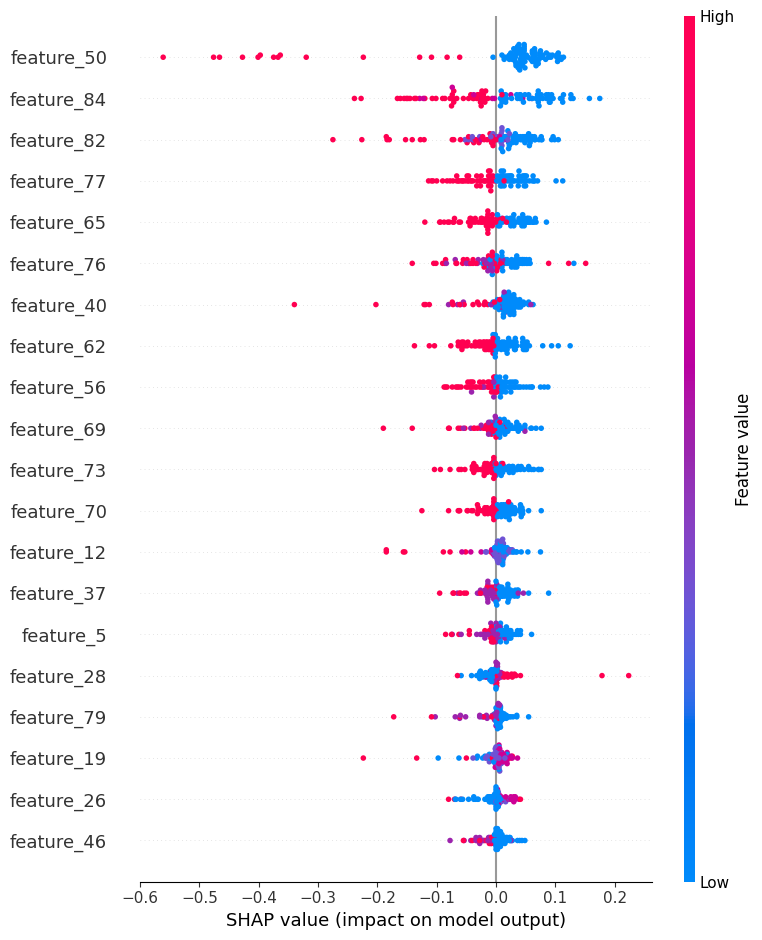

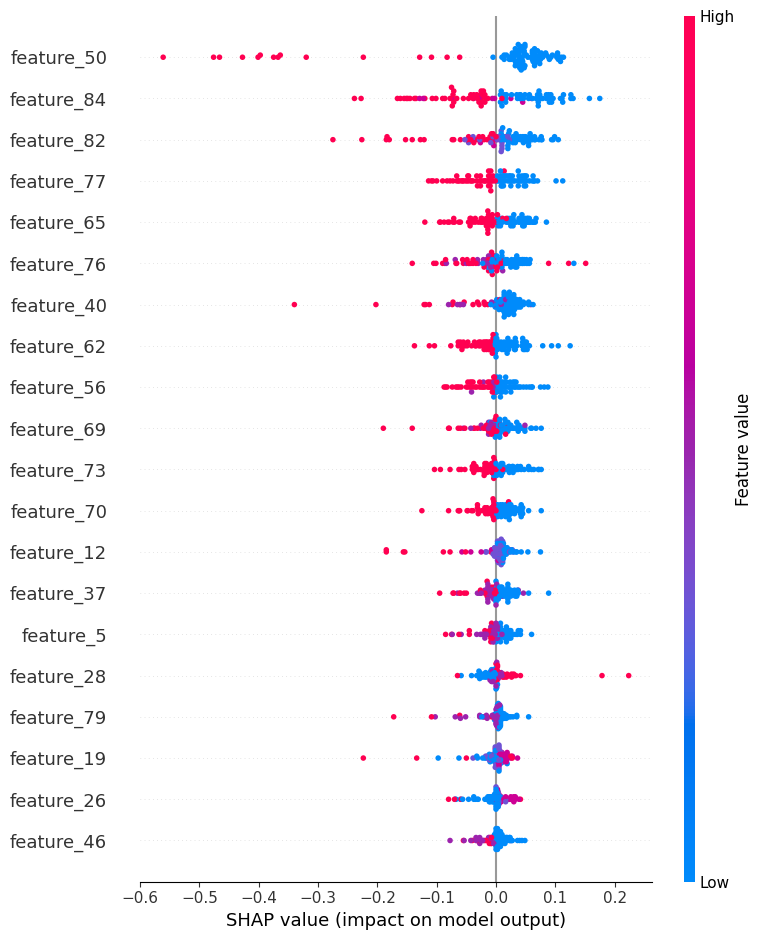

X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names

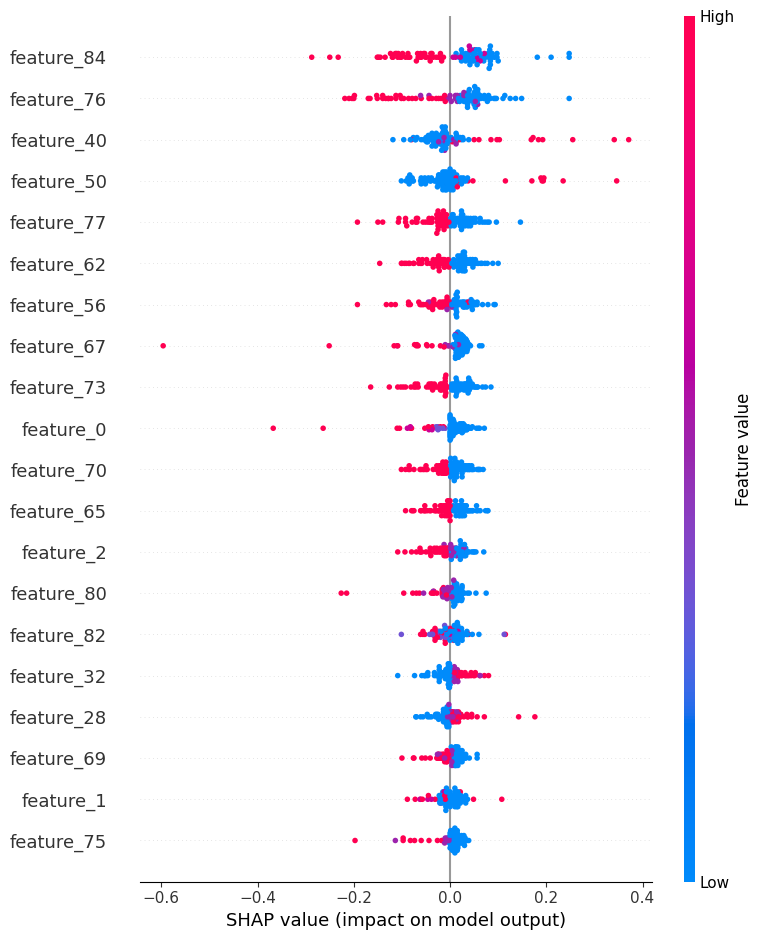

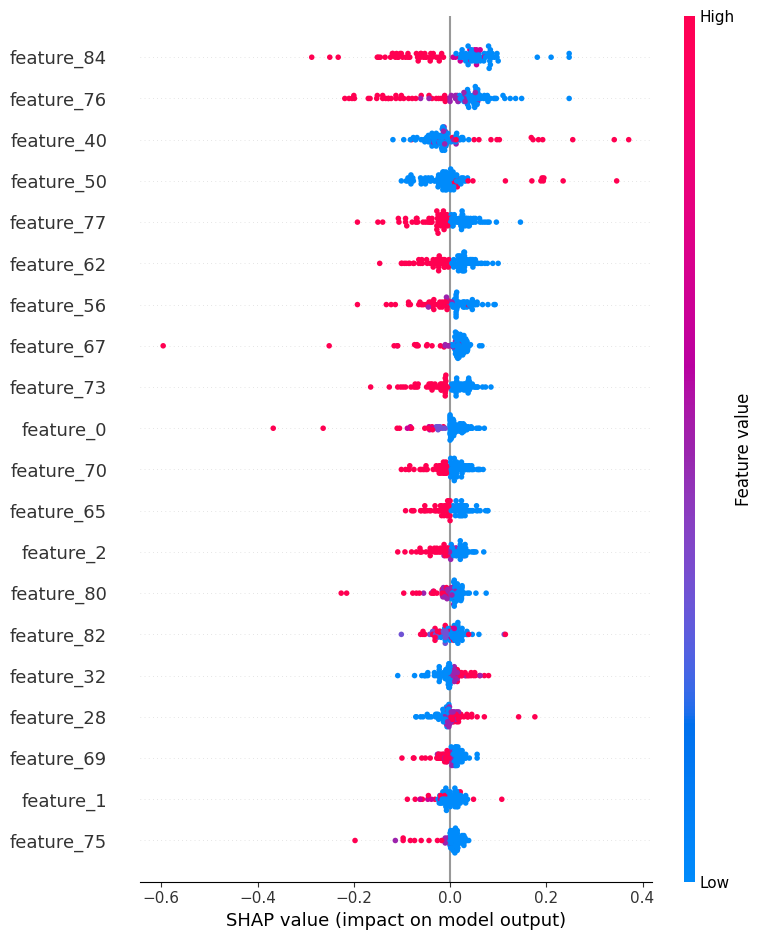

X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names

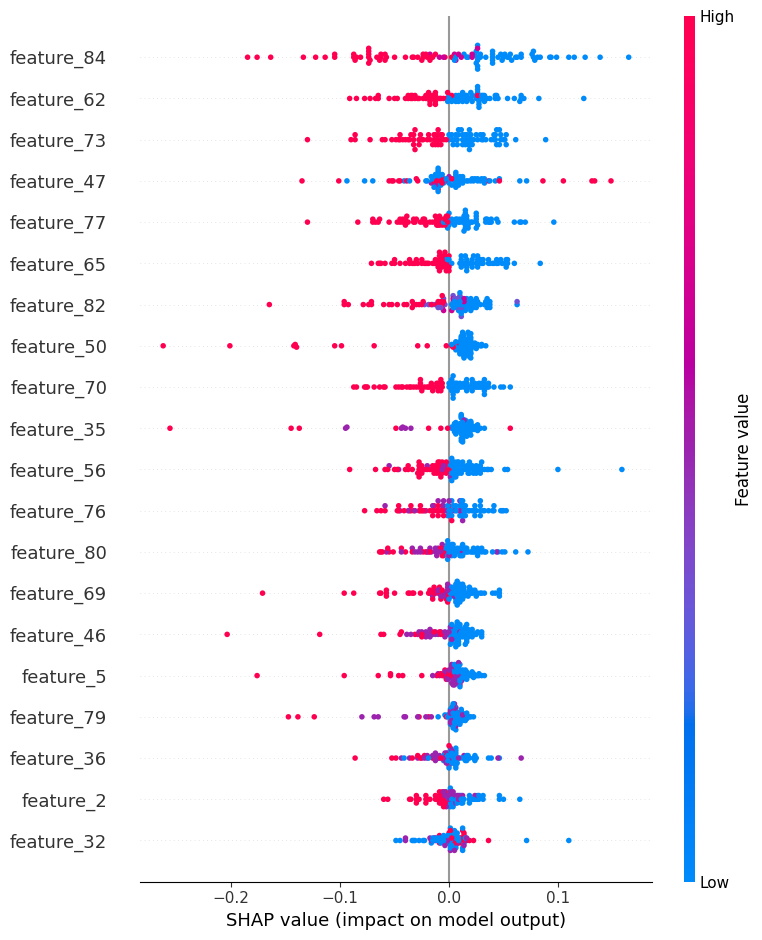

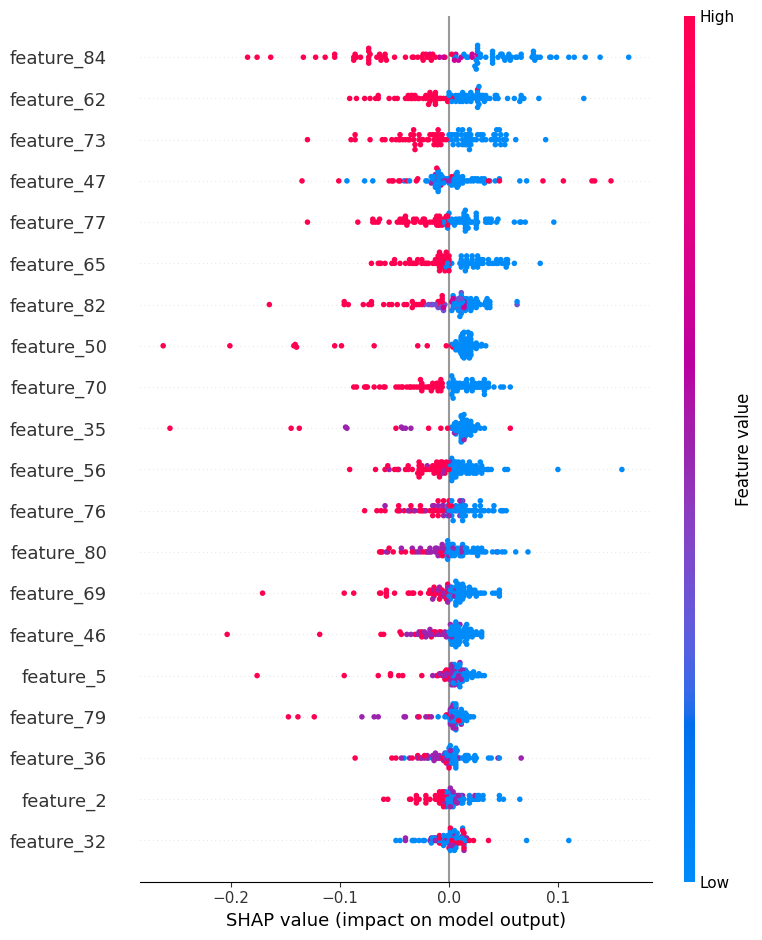

X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names

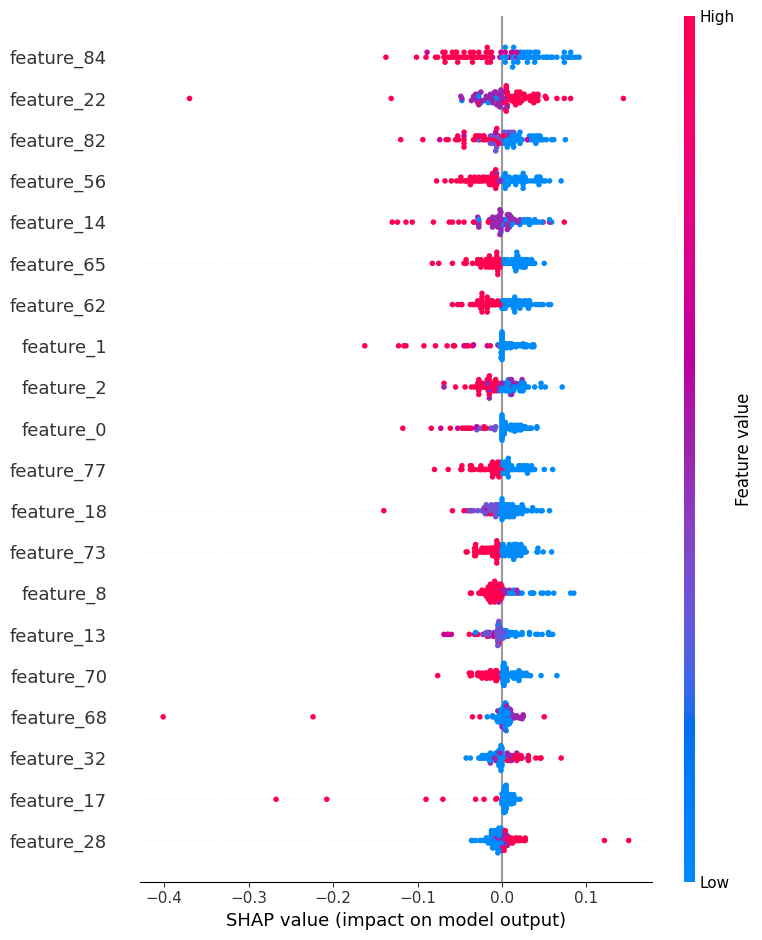

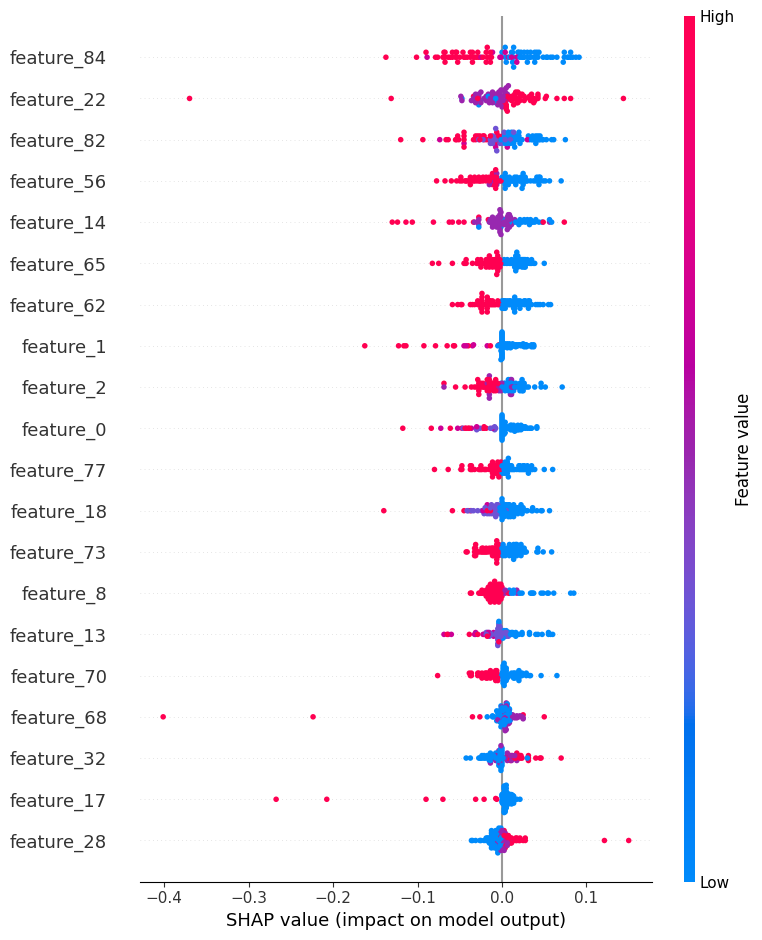

In [120]:
shap.initjs()    
plt.figure(figsize=(3,2))
for i in range(6):
    masker = shap.maskers.Independent(data=X)
    explainer = shap.Explainer(lambda x: model_predict(x,res[3][i]), masker)
    shap_values = explainer.shap_values(X)
    ax = shap.summary_plot(shap_values, X)
    
    # Adjust y-axis label size
    for label in plt.gca().get_yticklabels():
        label.set_fontsize(4)  # Adjust '8' to your preference

    shap.summary_plot(shap_values, X)
    #plt.show()
    #plt.gcf().canvas.draw()